# 3. Flow Matching: Why SD3 and FLUX Need Fewer Steps
**From Curved Diffusion Paths to Straight Flows**

## DDPM Revisited — The Problem

In our previous notebook we saw how DDPM works: it adds noise following a **fixed Markov chain** (an SDE formulation), then learns to reverse the process step by step.

The reverse process, however, follows **curved trajectories** through latent space. Each denoising step corrects a little noise, but the path from pure noise back to a clean image is anything but straight — it winds and bends through high-dimensional space.

### Why is this a problem?

Curved paths are hard to follow with large steps. If you take too big a step along a curve, you overshoot and end up far from where you should be. This is why DDPM needs **50 to 1000 steps** to produce high-quality images.

> **Analogy:** It’s like navigating a winding mountain road — you need many small turns to stay on the path. Take one big leap and you’ll fly off a cliff. But what if the road were a straight highway instead? Then you could cover the same distance in just a few strides.

This is exactly the insight behind **Flow Matching**.

## Flow Matching — The Key Idea

Instead of learning a **noise predictor** $\epsilon_\theta(x_t, t)$ like DDPM, Flow Matching learns a **velocity field** $v_\theta(x_t, t)$.

### The ODE Formulation

The generative process is defined by an ordinary differential equation (ODE):

$$\frac{dx}{dt} = v_\theta(x_t, t), \quad t \in [0, 1]$$

where $t = 0$ corresponds to **pure noise** and $t = 1$ corresponds to **clean data**.

### Rectified Flow: The Straight-Line Interpolation

The key design choice is how we define the interpolation between noise and data. **Rectified Flow** uses the simplest possible path — a straight line:

$$x_t = (1 - t) \cdot \varepsilon + t \cdot x_0$$

where $\varepsilon \sim \mathcal{N}(0, I)$ is noise and $x_0$ is a data sample.

### The Velocity is Trivially Simple

If we differentiate $x_t$ with respect to $t$, we get the velocity:

$$v = \frac{dx_t}{dt} = x_0 - \varepsilon$$

This is **constant** along the path! The velocity doesn’t change with time — it’s just the direction from noise to data.

### Training Loss

The training objective is to match this target velocity:

$$\mathcal{L} = \mathbb{E}_{t, x_0, \varepsilon} \left[ \|v_\theta(x_t, t) - (x_0 - \varepsilon)\|^2 \right]$$

**Result:** The model learns to push samples along **straight lines** from noise to data. And straight lines can be traversed in far fewer steps.

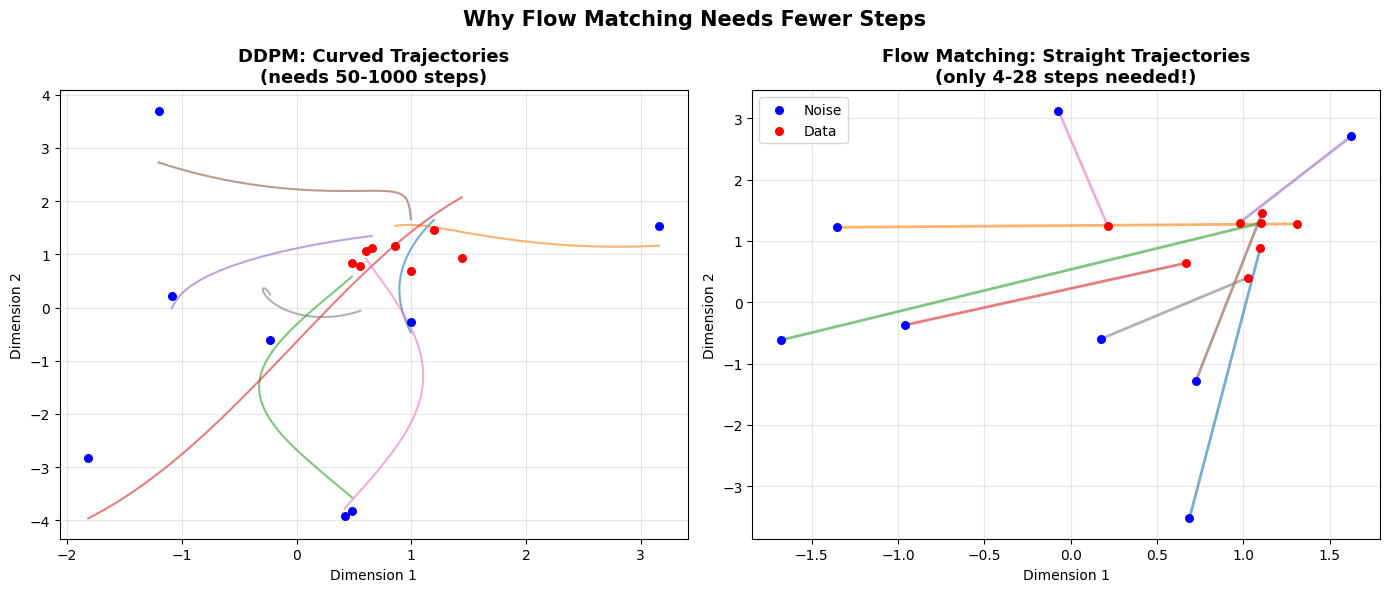

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulate 2D trajectories
n_trajectories = 8
n_steps = 50

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# DDPM: Curved trajectories (simulated with random walk bias)
for i in range(n_trajectories):
    start = np.random.randn(2) * 2  # noise
    end = np.array([1.0, 1.0]) + np.random.randn(2) * 0.3  # data
    t = np.linspace(0, 1, n_steps)
    # Add curvature via random perturbations
    curve = np.column_stack([
        start[0] + (end[0] - start[0]) * t + 0.8 * np.sin(np.pi * t) * np.random.randn(),
        start[1] + (end[1] - start[1]) * t + 0.8 * np.cos(np.pi * t) * np.random.randn(),
    ])
    ax1.plot(curve[:, 0], curve[:, 1], alpha=0.6, linewidth=1.5)
    ax1.scatter(*start, c='blue', s=30, zorder=5)
    ax1.scatter(*end, c='red', s=30, zorder=5)

ax1.set_title('DDPM: Curved Trajectories\n(needs 50-1000 steps)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.grid(True, alpha=0.3)

# Flow Matching: Straight trajectories
for i in range(n_trajectories):
    start = np.random.randn(2) * 2  # noise
    end = np.array([1.0, 1.0]) + np.random.randn(2) * 0.3  # data
    ax2.plot([start[0], end[0]], [start[1], end[1]], alpha=0.6, linewidth=2)
    ax2.scatter(*start, c='blue', s=30, zorder=5, label='Noise' if i == 0 else '')
    ax2.scatter(*end, c='red', s=30, zorder=5, label='Data' if i == 0 else '')

ax2.set_title('Flow Matching: Straight Trajectories\n(only 4-28 steps needed!)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Why Flow Matching Needs Fewer Steps', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Mathematical Comparison: DDPM vs Flow Matching

| | **DDPM** | **Flow Matching** |
|---|------|---------------|
| **Formulation** | SDE (stochastic) | ODE (deterministic) |
| **Forward process** | $x_t = \sqrt{\bar\alpha_t}\, x_0 + \sqrt{1-\bar\alpha_t}\, \varepsilon$ | $x_t = (1-t)\,\varepsilon + t\, x_0$ |
| **Prediction target** | Noise $\varepsilon$ | Velocity $v = x_0 - \varepsilon$ |
| **Loss** | $\\|\varepsilon - \varepsilon_\theta(x_t, t)\\|^2$ | $\\|v - v_\theta(x_t, t)\\|^2$ |
| **Trajectories** | Curved (SDE) | Straight (ODE) |
| **Typical steps** | 50–1000 | 4–50 |

### Key Insight

These two formulations are **mathematically related** — flow matching can be seen as a more elegant reparameterization of the diffusion process. The straight-line interpolation naturally leads to straighter paths in the learned ODE, which in turn allows accurate integration with far fewer steps.

You can think of it this way: DDPM’s noise schedule creates a complex, curved mapping between noise and data. Flow matching’s linear interpolation creates a simple, direct mapping. The neural network’s job is easier in the second case, and the resulting ODE is easier to solve.

## Toy Implementation — Learning a 2D Flow

Now we’ll train a tiny neural network to learn a flow from a **Gaussian distribution** to the **Swiss Roll distribution**. This demonstrates the core idea of Flow Matching in a visual, intuitive way.

No GPU needed — the model is small enough to train on CPU in under a minute.

In [3]:
!pip3 install 

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [ ]:
%pip install scikit-learn

from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np

# Generate Swiss Roll (2D projection)
n_samples = 5000
X_3d, color = make_swiss_roll(n_samples, noise=0.5, random_state=42)
# Use only the 2D projection (x and z coordinates)
X_data = np.column_stack([X_3d[:, 0], X_3d[:, 2]])
# Normalize to [-1, 1]
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

noise = np.random.randn(n_samples, 2)
ax1.scatter(noise[:, 0], noise[:, 1], s=1, alpha=0.3, c='blue')
ax1.set_title('Source: Gaussian Noise (t=0)', fontsize=12, fontweight='bold')
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

ax2.scatter(X_data[:, 0], X_data[:, 1], s=1, alpha=0.3, c=color, cmap='viridis')
ax2.set_title('Target: Swiss Roll (t=1)', fontsize=12, fontweight='bold')
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.suptitle('Flow Matching Goal: Transport Noise \u2192 Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SimpleVelocityNet(nn.Module):
    """Tiny MLP that predicts velocity v(x_t, t)."""
    def __init__(self, dim=2, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden),  # +1 for time
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, x, t):
        # t is scalar or (batch, 1)
        if t.dim() == 0:
            t = t.unsqueeze(0).expand(x.shape[0], 1)
        elif t.dim() == 1:
            t = t.unsqueeze(1)
        return self.net(torch.cat([x, t], dim=1))

# Training
model = SimpleVelocityNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_tensor = torch.FloatTensor(X_data)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

losses = []
for epoch in range(100):
    epoch_loss = 0
    for (x1,) in loader:
        x0 = torch.randn_like(x1)  # noise
        t = torch.rand(x1.shape[0])  # random timestep in [0, 1]

        # Rectified flow interpolation: x_t = (1-t)*x0 + t*x1
        t_expanded = t.unsqueeze(1)
        x_t = (1 - t_expanded) * x0 + t_expanded * x1

        # Target velocity: v = x1 - x0 (straight line direction)
        v_target = x1 - x0

        # Predict velocity
        v_pred = model(x_t, t)

        loss = ((v_pred - v_target) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    losses.append(epoch_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Flow Matching Training Loss', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
@torch.no_grad()
def euler_sample(model, n_samples=3000, n_steps=50):
    """Generate samples using Euler integration of the learned velocity field."""
    x = torch.randn(n_samples, 2)  # Start from noise
    dt = 1.0 / n_steps
    trajectory = [x.numpy().copy()]

    for i in range(n_steps):
        t = torch.ones(n_samples) * (i * dt)
        v = model(x, t)
        x = x + v * dt
        if i % (n_steps // 10) == 0:
            trajectory.append(x.numpy().copy())

    trajectory.append(x.numpy().copy())
    return x.numpy(), trajectory

# Generate with different step counts
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

step_counts = [4, 10, 25, 50]
for ax, n_steps in zip(axes, step_counts):
    samples, _ = euler_sample(model, n_samples=3000, n_steps=n_steps)
    ax.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.3, c='purple')
    ax.scatter(X_data[:500, 0], X_data[:500, 1], s=1, alpha=0.1, c='green')
    ax.set_title(f'{n_steps} Steps', fontsize=12, fontweight='bold')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle('Generated Samples at Different Step Counts\n(Purple=Generated, Green=Real Data)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
@torch.no_grad()
def plot_velocity_field(model, t_value, ax, title):
    """Plot the velocity field at a given timestep."""
    grid_size = 20
    x_range = np.linspace(-3, 3, grid_size)
    y_range = np.linspace(-3, 3, grid_size)
    xx, yy = np.meshgrid(x_range, y_range)
    points = torch.FloatTensor(np.column_stack([xx.ravel(), yy.ravel()]))
    t = torch.ones(points.shape[0]) * t_value

    velocities = model(points, t).numpy()
    vx = velocities[:, 0].reshape(grid_size, grid_size)
    vy = velocities[:, 1].reshape(grid_size, grid_size)

    ax.quiver(xx, yy, vx, vy, np.sqrt(vx**2 + vy**2), cmap='coolwarm', alpha=0.8)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
timesteps = [0.0, 0.25, 0.5, 0.75]
for ax, t_val in zip(axes, timesteps):
    plot_velocity_field(model, t_val, ax, f't = {t_val:.2f}')

plt.suptitle('Learned Velocity Field at Different Timesteps', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Connection to SD3 and FLUX.1

The toy model above demonstrates the **exact same principle** that powers Stable Diffusion 3 and FLUX.1 — just at a vastly different scale:

| | **Our Toy Model** | **SD3 / FLUX.1** |
|---|---|---|
| **Data** | 2D points (Swiss Roll) | 64×64×16 latent tensors |
| **Model** | 3-layer MLP (~50K params) | MMDiT (2B–12B params) |
| **Input** | 2D coordinates + time | Latent patches + text embeddings + time |
| **Training** | 100 epochs, < 1 minute | Thousands of GPU-hours |

### Why FLUX.1-schnell works in just 4 steps

1. **Rectified Flow** provides straight trajectories that are easy to integrate
2. **Guidance distillation** removes the need for classifier-free guidance (which normally doubles compute)
3. **The MMDiT architecture** has enough capacity to learn very accurate velocity fields

The result: a model that generates photorealistic images in **4 steps** instead of the 50+ steps required by earlier diffusion models.

## Key Takeaways

1. **Flow Matching learns straight paths** from noise to data, compared to DDPM’s curved paths
2. **Straight paths need fewer integration steps** → dramatically faster generation
3. **The training objective is elegant**: just predict the velocity $v = x_0 - \varepsilon$ along the straight-line interpolation
4. **Our toy example demonstrates the same principle** that scales up to FLUX.1 and SD3
5. **Combined with the MMDiT architecture** (covered in the next notebook), this enables state-of-the-art image generation in as few as 4 steps

## References

- Lipman, Y., Chen, R. T. Q., Ben-Hamu, H., Nickel, M., & Le, M. (2022). [Flow Matching for Generative Modeling](https://arxiv.org/abs/2210.02747). *ICLR 2023*.
- Liu, X., Gong, C., & Liu, Q. (2022). [Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/abs/2209.03003). *ICLR 2023*.
- Esser, P., Kulal, S., Blattmann, A., Entezari, R., Müller, J., Saini, H., ... & Rombach, R. (2024). [Scaling Rectified Flow Transformers for High-Resolution Image Synthesis](https://arxiv.org/abs/2403.03206). *Stable Diffusion 3 Technical Report*.